# RTML LAB6 Mask R-CNN
# Chanapa Pananookooln | st121395

#### Introduction


This lab, we learn about Mask R-CNN. First, we load the torchvision model to do inference on the COCO dataset and see the evalutation results.

Then, we do inference on Cityscapes dataset and see the result.

Lastly, we fine-tune the model on Cityscapes data set and evaluate the model again.

## 1. Get the demo up and running.

I followed all the directions that Prof Matt shared in Piazza to load COCO dataset and inference the pretrained model.

Load the torchvision model
Ref: Prof Matt

In [1]:
from get_free_gpu import get_free_gpu

print(get_free_gpu())

cuda:1


#### load the model and COCO dataset

In [2]:
import torch
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.datasets import CocoDetection

import coco_codes.utils
from coco_codes.coco_utils import get_coco
import coco_codes.transforms as transforms

# Load a model pre-trained on COCO and put it in inference mode

print(model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).cuda(1)
model.eval()

# Load the COCO 2017 train and val sets. We use the CocoDetection class definition
# from ./coco_utils.py, not the original torchvision.CocoDetection class. Also, we
# use transforms from ./transforms, not torchvision.transforms, because they need
# to transform the bboxes and masks along with the image.

coco_path = "/root/labs/COCOdata"

transform = transforms.Compose([
    transforms.ToTensor()
])

print('Loading COCO train, val datasets...')
# coco_train_dataset = get_coco(coco_path, 'train', transform)
coco_val_dataset = get_coco(coco_path, 'val', transform)

def collate_fn(batch):
    return tuple(zip(*batch))

val_dataloader = torch.utils.data.DataLoader(coco_val_dataset, batch_size=1, shuffle=True, num_workers=4, collate_fn=collate_fn)

Loading pretrained model...
Loading COCO train, val datasets...
loading annotations into memory...
Done (t=1.16s)
creating index...
index created!


#### Print the shapes of the output of the model

In [3]:
images, targets = next(iter(val_dataloader))

images = [ img.cuda(1) for img in images ]
predictions = model(images)

print('Prediction keys:', list(dict(predictions[0])))
print('Boxes shape:', predictions[0]['boxes'].shape)
print('Labels shape:', predictions[0]['labels'].shape)
print('Scores shape:', predictions[0]['scores'].shape)
print('Masks shape:', predictions[0]['masks'].shape)


Prediction keys: ['boxes', 'labels', 'scores', 'masks']
Boxes shape: torch.Size([100, 4])
Labels shape: torch.Size([100])
Scores shape: torch.Size([100])
Masks shape: torch.Size([100, 1, 428, 640])


#### Here are the functions for Drawing the predicted masks and bboxes.

In [13]:
import numpy as np
import cv2
import random

# Array of labels for COCO dataset (91 elements)

coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Random colors to use for labeling objects

COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3)).astype(np.uint8)

# Overlay masks, bounding boxes, and labels on input numpy image

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1
    beta = 0.5 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    # convert from RGB to OpenCV BGR format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for i in range(len(masks)):
        mask = masks[i,:,:]
        red_map = np.zeros_like(mask).astype(np.uint8)
        green_map = np.zeros_like(mask).astype(np.uint8)
        blue_map = np.zeros_like(mask).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[mask > 0.5] = color[0]
        green_map[mask > 0.5] = color[1]
        blue_map[mask > 0.5] = color[2]
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        # apply colored mask to the image
        image = cv2.addWeighted(image, alpha, segmentation_map, beta, gamma)
        # draw the bounding box around each object
        p1 = (int(boxes[i][0]), int(boxes[i][1]))
        p2 = (int(boxes[i][2]), int(boxes[i][3]))
        color = (int(color[0]), int(color[1]), int(color[2]))
        cv2.rectangle(image, p1, p2, color, 2)
        # put the label text above the objects
        p = (int(boxes[i][0]), int(boxes[i][1]-10))
        cv2.putText(image, labels[i], p, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)
    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Overlay masks, bounding boxes, and labels of objects with scores greater than
# threshold on one of the images in the input tensor using the predictions output by Mask R-CNN.

def prediction_to_mask_image(images, predictions, img_index, threshold):
    scores = predictions[img_index]['scores']
    boxes_to_use = scores >= threshold
    img = (images[img_index].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    masks = predictions[img_index]['masks'][boxes_to_use, :, :].cpu().detach().squeeze(1).numpy()
    boxes = predictions[img_index]['boxes'][boxes_to_use, :].cpu().detach().numpy()
    labels = predictions[img_index]['labels'][boxes_to_use].cpu().numpy()
    labels = [ coco_names[l] for l in labels ]

    return draw_segmentation_map(img, masks, boxes, labels)

#### Visualize the predictions for a random image in the validation set, using a threshold of 0.5:

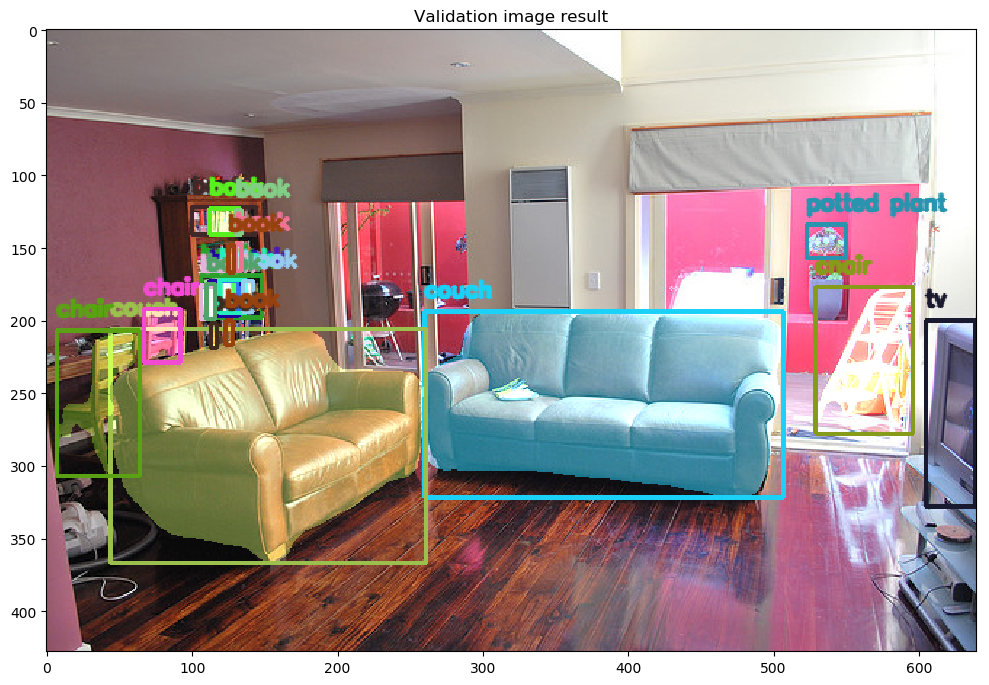

In [5]:
from matplotlib import pyplot as plt

masked_img = prediction_to_mask_image(images, predictions, 0, 0.5)
plt.figure(1, figsize=(12, 9), dpi=100)
plt.imshow(masked_img)
plt.title('Validation image result')
plt.show()

#### Results

#### From the output we can see that the model that was pretrained on COCO did a very good job at detecting the bbox and instance segmentations on validation image from COCO.

## 2. Evaluate the pretrained COCO model on the COCO validation set we used last week.

#### Run the prediction on the validation set to calculate the average precision and average recall of the bbox and segmentation.

In [5]:
from engine import evaluate

results = evaluate(model, val_dataloader, 'cuda:1')

Test:  [  0/625]  eta: 0:11:49  model_time: 0.4978 (0.4978)  evaluator_time: 0.2335 (0.2335)  time: 1.1358  data: 0.4002  max mem: 12871
Test:  [100/625]  eta: 0:06:12  model_time: 0.4845 (0.4848)  evaluator_time: 0.1976 (0.1987)  time: 0.7205  data: 0.0134  max mem: 13892
Test:  [200/625]  eta: 0:05:07  model_time: 0.5174 (0.4874)  evaluator_time: 0.2214 (0.2095)  time: 0.7613  data: 0.0138  max mem: 13892
Test:  [300/625]  eta: 0:03:52  model_time: 0.4706 (0.4826)  evaluator_time: 0.1945 (0.2080)  time: 0.7470  data: 0.0138  max mem: 13892
Test:  [400/625]  eta: 0:02:40  model_time: 0.4712 (0.4833)  evaluator_time: 0.1781 (0.2052)  time: 0.7040  data: 0.0138  max mem: 13892
Test:  [500/625]  eta: 0:01:29  model_time: 0.4539 (0.4823)  evaluator_time: 0.1674 (0.2075)  time: 0.6716  data: 0.0139  max mem: 13892
Test:  [600/625]  eta: 0:00:17  model_time: 0.4502 (0.4820)  evaluator_time: 0.1961 (0.2059)  time: 0.6920  data: 0.0141  max mem: 13893
Test:  [624/625]  eta: 0:00:00  model_tim

#### Results

#### We see mAP of 0.37881 for bounding boxes and 0.34600 for masks.

## 3. Download the Cityscapes dataset and run Mask R-CNN on it in inference model. Report your results and see what errors you find.

#### I got the CityscapesDataset class for loading the Cityscapes dataset images from here :
#### https://github.com/goldbattle/pytorch_unet

#### This helps with loading the images that can then be used for inference

#### Load the pretrained model

In [10]:
import torch
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from datasets import CityscapesDataset

import coco_codes.utils
import coco_codes.transforms

print('Loading pretrained model...')
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).cuda(3)
model.eval()

Loading pretrained model...


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

#### The CityscapesDataset class I used.
#### This resized all of the images into size 128, 256 which is quite small when compared to the original image but it is still compatible with the functions for visualizing the masks and bboxes

In [ ]:
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.transforms.functional as TF
from collections import namedtuple


class CityscapesDataset(Dataset):

    def __init__(self, root, split='train', mode='fine', augment=False):

        self.root = os.path.expanduser(root)
        self.mode = 'gtFine' if mode == 'fine' else 'gtCoarse'
        self.images_dir = os.path.join(self.root, 'leftImg8bit', split)
        self.targets_dir = os.path.join(self.root, self.mode, split)
        self.split = split
        self.augment = augment
        self.images = []
        self.targets = []
        self.mapping = {
            0: 0,  # unlabeled
            1: 0,  # ego vehicle
            2: 0,  # rect border
            3: 0,  # out of roi
            4: 0,  # static
            5: 0,  # dynamic
            6: 0,  # ground
            7: 1,  # road
            8: 0,  # sidewalk
            9: 0,  # parking
            10: 0,  # rail track
            11: 0,  # building
            12: 0,  # wall
            13: 0,  # fence
            14: 0,  # guard rail
            15: 0,  # bridge
            16: 0,  # tunnel
            17: 0,  # pole
            18: 0,  # polegroup
            19: 0,  # traffic light
            20: 0,  # traffic sign
            21: 0,  # vegetation
            22: 0,  # terrain
            23: 2,  # sky
            24: 0,  # person
            25: 0,  # rider
            26: 3,  # car
            27: 0,  # truck
            28: 0,  # bus
            29: 0,  # caravan
            30: 0,  # trailer
            31: 0,  # train
            32: 0,  # motorcycle
            33: 0,  # bicycle
            -1: 0  # licenseplate
        }
        self.mappingrgb = {
            0: (255, 0, 0),  # unlabeled
            1: (255, 0, 0),  # ego vehicle
            2: (255, 0, 0),  # rect border
            3: (255, 0, 0),  # out of roi
            4: (255, 0, 0),  # static
            5: (255, 0, 0),  # dynamic
            6: (255, 0, 0),  # ground
            7: (0, 255, 0),  # road
            8: (255, 0, 0),  # sidewalk
            9: (255, 0, 0),  # parking
            10: (255, 0, 0),  # rail track
            11: (255, 0, 0),  # building
            12: (255, 0, 0),  # wall
            13: (255, 0, 0),  # fence
            14: (255, 0, 0),  # guard rail
            15: (255, 0, 0),  # bridge
            16: (255, 0, 0),  # tunnel
            17: (255, 0, 0),  # pole
            18: (255, 0, 0),  # polegroup
            19: (255, 0, 0),  # traffic light
            20: (255, 0, 0),  # traffic sign
            21: (255, 0, 0),  # vegetation
            22: (255, 0, 0),  # terrain
            23: (0, 0, 255),  # sky
            24: (255, 0, 0),  # person
            25: (255, 0, 0),  # rider
            26: (255, 255, 0),  # car
            27: (255, 0, 0),  # truck
            28: (255, 0, 0),  # bus
            29: (255, 0, 0),  # caravan
            30: (255, 0, 0),  # trailer
            31: (255, 0, 0),  # train
            32: (255, 0, 0),  # motorcycle
            33: (255, 0, 0),  # bicycle
            -1: (255, 0, 0)  # licenseplate
        }

        # Ensure that this matches the above mapping!#!@#!@#
        # For example 4 classes, means we should map to the ids=(0,1,2,3)
        # This is used to specify how many outputs the network should product...
        self.num_classes = 4

        # =============================================
        # Check that inputs are valid
        # =============================================
        if mode not in ['fine', 'coarse']:
            raise ValueError('Invalid mode! Please use mode="fine" or mode="coarse"')
        if mode == 'fine' and split not in ['train', 'test', 'val']:
            raise ValueError('Invalid split for mode "fine"! Please use split="train", split="test" or split="val"')
        elif mode == 'coarse' and split not in ['train', 'train_extra', 'val']:
            raise ValueError('Invalid split for mode "coarse"! Please use split="train", split="train_extra" or split="val"')
        if not os.path.isdir(self.images_dir) or not os.path.isdir(self.targets_dir):
            raise RuntimeError('Dataset not found or incomplete. Please make sure all required folders for the'
                               ' specified "split" and "mode" are inside the "root" directory')

        # =============================================
        # Read in the paths to all images
        # =============================================
        for city in os.listdir(self.images_dir):
            img_dir = os.path.join(self.images_dir, city)
            target_dir = os.path.join(self.targets_dir, city)
            for file_name in os.listdir(img_dir):
                self.images.append(os.path.join(img_dir, file_name))
                target_name = '{}_{}'.format(file_name.split('_leftImg8bit')[0], '{}_labelIds.png'.format(self.mode))
                # target_name = '{}_{}'.format(file_name.split('_leftImg8bit')[0], '{}_color.png'.format(self.mode))
                self.targets.append(os.path.join(target_dir, target_name))

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of images: {}\n'.format(self.__len__())
        fmt_str += '    Split: {}\n'.format(self.split)
        fmt_str += '    Mode: {}\n'.format(self.mode)
        fmt_str += '    Augment: {}\n'.format(self.augment)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        return fmt_str

    def __len__(self):
        return len(self.images)

    def mask_to_class(self, mask):
        '''
        Given the cityscapes dataset, this maps to a 0..classes numbers.
        This is because we are using a subset of all masks, so we have this "mapping" function.
        This mapping function is used to map all the standard ids into the smaller subset.
        '''
        maskimg = torch.zeros((mask.size()[0], mask.size()[1]), dtype=torch.uint8)
        for k in self.mapping:
            maskimg[mask == k] = self.mapping[k]
        return maskimg

    def mask_to_rgb(self, mask):
        '''
        Given the Cityscapes mask file, this converts the ids into rgb colors.
        This is needed as we are interested in a sub-set of labels, thus can't just use the
        standard color output provided by the dataset.
        '''
        rgbimg = torch.zeros((3, mask.size()[0], mask.size()[1]), dtype=torch.uint8)
        for k in self.mappingrgb:
            rgbimg[0][mask == k] = self.mappingrgb[k][0]
            rgbimg[1][mask == k] = self.mappingrgb[k][1]
            rgbimg[2][mask == k] = self.mappingrgb[k][2]
        return rgbimg

    def class_to_rgb(self, mask):
        '''
        This function maps the classification index ids into the rgb.
        For example after the argmax from the network, you want to find what class
        a given pixel belongs too. This does that but just changes the color
        so that we can compare it directly to the rgb groundtruth label.
        '''
        mask2class = dict((v, k) for k, v in self.mapping.items())
        rgbimg = torch.zeros((3, mask.size()[0], mask.size()[1]), dtype=torch.uint8)
        for k in mask2class:
            rgbimg[0][mask == k] = self.mappingrgb[mask2class[k]][0]
            rgbimg[1][mask == k] = self.mappingrgb[mask2class[k]][1]
            rgbimg[2][mask == k] = self.mappingrgb[mask2class[k]][2]
        return rgbimg

    def __getitem__(self, index):

        # first load the RGB image
        image = Image.open(self.images[index]).convert('RGB')

        # next load the target
        target = Image.open(self.targets[index]).convert('L')

        # If augmenting, apply random transforms
        # Else we should just resize the image down to the correct size
        if self.augment:
            # Resize
            image = TF.resize(image, size=(128+10, 256+10), interpolation=Image.BILINEAR)
            target = TF.resize(target, size=(128+10, 256+10), interpolation=Image.NEAREST)
            # Random crop
            i, j, h, w = transforms.RandomCrop.get_params(image, output_size=(128, 256))
            image = TF.crop(image, i, j, h, w)
            target = TF.crop(target, i, j, h, w)
            # Random horizontal flipping
            if random.random() > 0.5:
                image = TF.hflip(image)
                target = TF.hflip(target)
            # Random vertical flipping
            # (I found this caused issues with the sky=road during prediction)
            # if random.random() > 0.5:
            #    image = TF.vflip(image)
            #    target = TF.vflip(target)
        else:
            # Resize
            image = TF.resize(image, size=(128, 256), interpolation=Image.BILINEAR)
            target = TF.resize(target, size=(128, 256), interpolation=Image.NEAREST)

        # convert to pytorch tensors
        # target = TF.to_tensor(target)
        target = torch.from_numpy(np.array(target, dtype=np.uint8))
        image = TF.to_tensor(image)

        # convert the labels into a mask
        targetrgb = self.mask_to_rgb(target)
        targetmask = self.mask_to_class(target)
        targetmask = targetmask.long()
        targetrgb = targetrgb.long()

        # finally return the image pair
        # return image, targetmask, targetrgb
        return image, targetmask

#### Load cityscapes validation set

In [11]:
cityscapes_path = "/root/labs/Cityscapes"

print('Loading Cityscapes val datasets...')
dataset = CityscapesDataset(cityscapes_path, split='val', mode='fine', augment=False)

print(dataset)

val_dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)

Loading Cityscapes val datasets...
Dataset CityscapesDataset
    Number of images: 500
    Split: val
    Mode: gtFine
    Augment: False
    Root Location: /root/labs/Cityscapes



#### Print shapes of the predicted outputs

In [12]:
images, targetmask = next(iter(val_dataloader))
print(images.shape)
print(targetmask.shape)

images = [ img.cuda(3) for img in images ]
predictions = model(images)


print('Prediction keys:', predictions[0].keys())
print('Boxes shape:', predictions[0]['boxes'].shape)
print('Labels shape:', predictions[0]['labels'].shape)
print('Scores shape:', predictions[0]['scores'].shape)
print('Masks shape:', predictions[0]['masks'].shape)

torch.Size([1, 3, 128, 256])
torch.Size([1, 128, 256])
Prediction keys: dict_keys(['boxes', 'labels', 'scores', 'masks'])
Boxes shape: torch.Size([36, 4])
Labels shape: torch.Size([36])
Scores shape: torch.Size([36])
Masks shape: torch.Size([36, 1, 128, 256])


#### Results

#### Visualization of the predicted masks and bboxes of the COCO pretrained Mask R-CNN model on a Cityscapes image.

#### We can see that the pretrained model also perform very well on the Cityscapes dataset.

#### Both the bboxes and the Masking are looking good and seems to be at the correct locations.

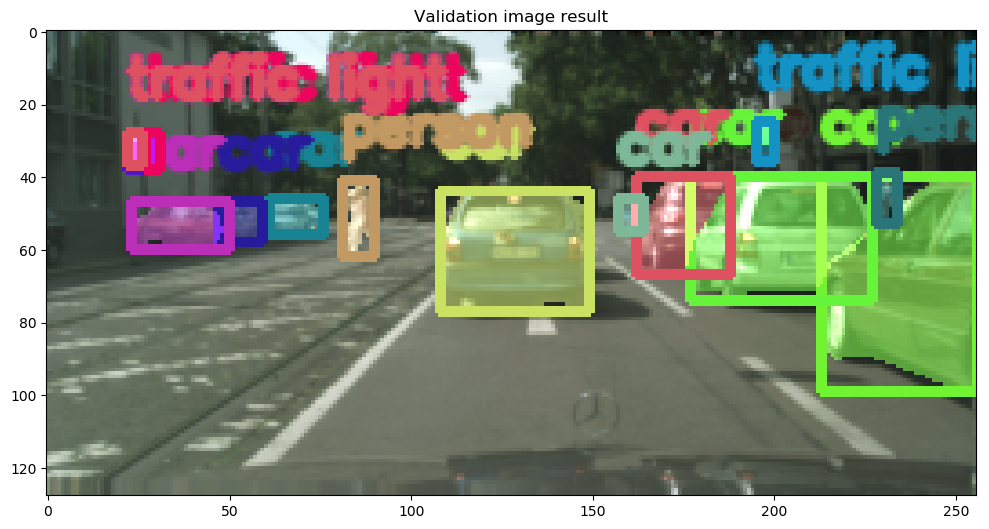

In [14]:
from matplotlib import pyplot as plt

masked_img = prediction_to_mask_image(images, predictions, 0, 0.5)
plt.figure(1, figsize=(12, 9), dpi=100)
plt.imshow(masked_img)
plt.title('Validation image result')
plt.show()